# O2AT tutorial: Neural Network regression

For any questions to this tutorial or further help, just write to me (Mattermost, Email: christian.sonnabend@cern.ch, etc.)<br>

**Instructions**
- Install the necessary libraries, if you haven't already: <font color='LightBlue'>pip install numpy matplotlib onnx onnxruntime scikit-learn uproot uproot3</font>
- For the PyTorch installation please choose the correct operating system: https://pytorch.org/
- You can execute each code cell by pressing 'Shift + Enter' or the ▷ button on the side of each cell

We will start by importing some modules we will need

In [221]:
### Some modules we will need

import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import scipy as sc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import onnx
import onnxruntime as ort

### Global figure size
matplotlib.rcParams['figure.figsize'] = (12,7)

### Formatting, might not work in VSCode, but it's not a problem
### It's used for numbering the equations
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

UsageError: Line magic function `%%javascript` not found.


## 1) Preamble

Neural networks are powerful regression tools that have gained tremendous popularity in the recent years. While it is typically presented that ML can be divided into classification and regression, it is only part of the magic that goes on behind the curtain. Externally, a neural network can be thought of as a funcion that maps from an input space of basically arbitrary dimensions to an output space. While input and output are clearly defined by the user, the internal workings of neural networks can only be understood in rare cases (basically only when the network is structured in a certain way, e.g. Graph Neural Networks (GNN)). Understanding the internal parameters (weights and biases) of a neural network is like trying to track an N-particle simulation: You won't succeed just doing it by hand. You need algorithms!<br>

The full neural network is complex and inter-linked, however it's constituents are not! A single neuron is typically just a simple function (ReLU, Tanh, or logisitc sigmoid) that takes the input from the previous layer (X), multiplies it with an internal weight matrix (W), adds a bias term (B) evaluates the function and passes it on to the next layer.

$\begin{equation}
Y = \sigma(W\cdot X + B) \in \mathbb{R}
\end{equation}$

Since every node is constructed in such a simple way, it is easy to calculate gradients. This will then also be our fundamental tool for improving the network: Update the weights using the gradients such that the network approximates our task as good as possible.<br>

All of this is handeled internally within our framework (pytorch). We just have to define WHAT we want the network to learn and HOW.

## 2) Basics

As explained in the talk on monday it is best to start with a bit of human intuition about how one would go about the topic of regression. Imagine you have a function which can take any arbitrary shape, but you have to adjust this function such that it best describes your data-points.<br>

<font color='green'>**What does it mean to best describe your datapoints?**</font>

Well, for regression there is a typical measure when you have a set of datapoints (X) with target values (Y), each associated with an uncertainty ($\sigma$) and a model prediction ($\hat{Y}$) for each datapoint (i) in your dataset

$
\begin{equation}
\chi^2 = \sum_{i=1}^{n}\bigg(\frac{Y_i - \hat{Y}_i}{\sigma_i}\bigg)^2
\end{equation}
$

<font color='green'>**But what if we don't have any errors on our datapoints and we just want to fit some arbitrary data?**</font>

For this case we imagine that the error on every datapoint is the same. To avoid prefactors, we choose that $\sigma_i = 1$. We arrive at the sum of squared errors (SSE)

$
\begin{equation}
\text{SSE} = \sum_{i=1}^{n}({Y_i - \hat{Y}_i})^2
\end{equation}
$

To keep numbers smaller (especially for larger datasets), it is useful to calcualte the average error per datapoint. Hence the measure for approximating a regression task, the so called <font color='orange'>loss function</font>, that is typically used is the mean squared error (MSE)

$
\begin{equation}
\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}({Y_i - \hat{Y}_i})^2
\end{equation}
$

This is a typical score used for regression and in general also for model evaluation. Using the loss, the weights can be adjusted by an algorithm called <font color='orange'>backpropagation</font>. This algorithm internally performs a <font color='orange'>gradient descent</font> using certain update rules (so called optimizers, e.g. Stochastic Gradient Descent (SGD), Adagrad, Adam, etc.) to update the internal parameters $\theta$ of our network, containing all the weights and biases of each neuron. For this the gradient is calculated from the loss function to the last (output) layer of the neural network. For a neuron in the last layer L, we write $\hat{Y} = X_L = \sigma_L(Z_L) = \sigma_L(X_{L-1} \cdot W_L)$, where the bias-term is just appended to the weight matrix W and a row of ones is appended to the input X. Hence, we get

$
\begin{equation}
\delta_L = \frac{\partial\text{Loss}}{\partial Z_L}
\end{equation}
$

From this we can calcualte the gradient w.r.t. the weights $W_L$ of the last layer as

$
\begin{equation}
\frac{\partial\text{Loss}}{\partial W_L} = \frac{\partial\text{Loss}}{\partial Z_L}\cdot\frac{\partial Z_L}{\partial W_L} = X_{L-1}^T \cdot\delta_L 
\end{equation}
$

By the chain rule, this can be extended to layer l-1 as

$
\begin{equation}
\delta_{L-1} = \frac{\partial\text{Loss}}{\partial Z_L}\cdot\frac{\partial Z_L}{\partial X_L}\cdot\frac{\partial X_L}{\partial Z_L} = \delta_L\cdot W_L^T\cdot\text{diag}(\sigma'_{l-1}(Z_{L-1}))
\end{equation}
$

We have a recursion formula! Therefore we can update the weights at each step (what a "step" is will be defined momentarily) using gradient descent (or any other, more complex variant of it -> optimizers) by doing a full forward pass, saving $X_l$ for every layer $l$ and then a backward pass through the network calculating

$
\begin{align}
\Delta W_l &+= Z_{L-1}^T\cdot\delta_l\\
\delta_{l-1} &= \delta_{l}\cdot (W_l^{(t-1)})^T\cdot\text{diag}(\sigma'_{l-1}(Z_{l-1}))
\end{align}
$

which leads to the final update of weights as

$
\begin{equation}
W_l^{t} = W_l^{t-1} + \tau\cdot\Delta W_l
\end{equation}
$

where $\tau$ is the <font color='orange'>learning rate</font>. Any other preffered method of optimization for updating the weights can be used here. (Please let me know if you find any inconsitencies in the formulas above, I'm also just a human 😉)<br>

The neural network training is usually performed in epochs: Your data is divided into a training and test dataset (typically 80/20 division) which is passed through the network fully once per iteration. This means that the network loops many times over your dataset until you are satisfied with its performance, typically measured by the loss score. However what might happen is that the full dataset covers a vast area of your phase-space and hence calculating the gradient once for the full dataset might not be very representative and might not help the network to learn well. For this, it is highly recommended to divide your training data into <font color='orange'>(mini-)batches</font>. This means that per epoch the network still loops once over the full data but the weights are updated $n$ times if you divide your training dataset into $n$ (equally sized) batches. This is what was previously meant with "steps": Gradients are calculated for each batch and passed backwards through the network.

Now that you know the basic terminologies, we can continue to some real data!

## 3) Regression in 1D

Let's start with the most simple example: Fitting some 1D data. We will start from an analytic function that we define, such that we can see how our network performs in the end

In [222]:
# Define our test function
def test_function(x):
    return (np.sin(0.3*x)**2 + 0.7*np.cos(2*x+np.pi/2.) + np.sin(0.3*x))/3.

# Adding some jitter to the evaluation
def jittered_function(range=[10,20], num_points = 1000, fluc=1, func=test_function):
    axis = np.linspace(*range, num_points)
    jitter = np.random.uniform(-fluc,fluc, (2,num_points))
    return axis, func(axis + jitter[0]) + jitter[1]

In [223]:
data_reg1d = jittered_function([-2,2], 10000, 0.05)

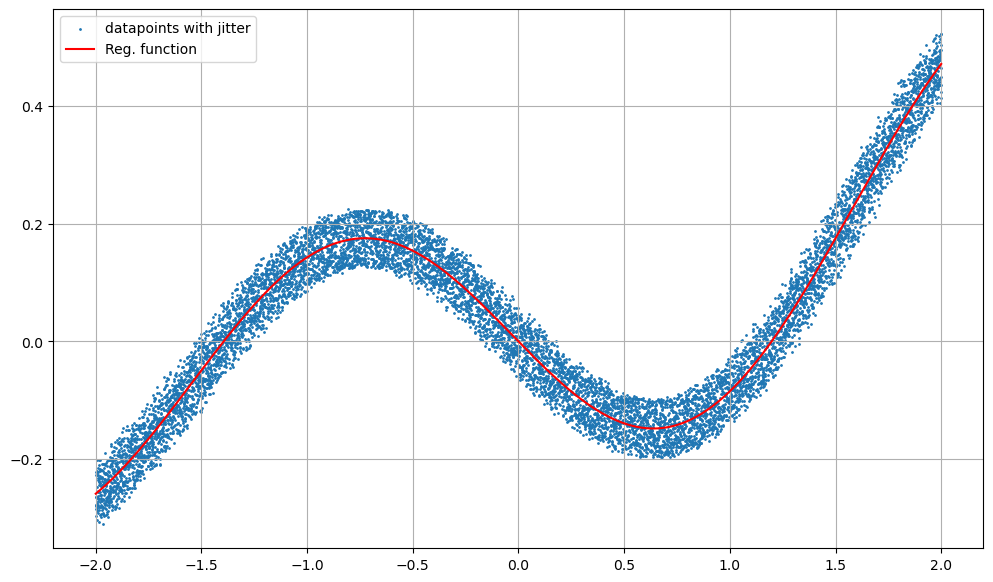

In [224]:
# Plotting the data and the function

plt.scatter(*data_reg1d, s=1, label='datapoints with jitter')
plt.plot(data_reg1d[0], test_function(data_reg1d[0]), c='r', label='Reg. function')
plt.legend()
plt.grid()
plt.show()

This example might be oversimplified, but it illustrates nicely how a neural network regression works. In real data you might have to deal with larger outliers or higher fluctuations in different regions of the input <font color='orange'>phase space</font>. One other aspect to consider is that there is no one-fits-all solution to every problem. Your network has to be tailored to your problem. The <font color='orange'>universal approximation theroem</font> for neural networks states that a one-layer neural network $N(x)$ with a sufficient number of neurons in the first layer can fit any function $f(x)$ to arbitrary precision

$
\begin{equation}
\sup_{x\in K\subseteq\mathbb{R}^n}\parallel N(x) - f(x)\parallel\leq\epsilon.
\end{equation}
$

In practice it is however a well-known fact that deep neural networks (more layers) can fit functions much better than shallow or even one-layer neural networks with a significantly lower number of total neurons. We continue with constructing the neural network.

In [225]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        ### network layers
        self.fc1 = nn.Linear(1, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 1)
        
        ### activation functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        
        ### network structure
        out = self.tanh(self.fc1(x))
        out = self.tanh(self.fc2(out))
        out = self.tanh(self.fc3(out))
        out = self.tanh(self.fc4(out))
        out = self.fc5(out)
        
        return out


class Trainer:
    def __init__(self, model, train_loader, val_loader=None, lr=0.001):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.lr = lr
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train(self, epochs):
        for epoch in range(epochs):
            train_loss = 0.0
            val_loss = 0.0
            for i, (inputs, targets) in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(self.train_loader)
            if self.val_loader is not None:
                with torch.no_grad():
                    for inputs, targets in self.val_loader:
                        outputs = self.model(inputs)
                        loss = self.criterion(outputs, targets)
                        val_loss += loss.item()
                    val_loss /= len(self.val_loader)
                    print("Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}".format(epoch+1, train_loss, val_loss))
            else:
                print("Epoch: {}, Training Loss: {:.4f}".format(epoch+1, train_loss))

In [247]:
# Generate some sample data and instanciating the network
x_train, x_test, y_train, y_test = train_test_split(data_reg1d[0], data_reg1d[1], test_size=0.2, shuffle=True)
x_train, x_test, y_train, y_test = torch.tensor(x_train.reshape(-1,1)).float(), torch.tensor(x_test.reshape(-1,1)).float(), torch.tensor(y_train.reshape(-1,1)).float(), torch.tensor(y_test.reshape(-1,1)).float()
net = Net()

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
val_loader = DataLoader(val_dataset, batch_size=10000)

# Train the neural network

trainer = Trainer(model=net, train_loader=train_loader, val_loader=val_loader, lr=0.003)
trainer.train(epochs=10)

Epoch: 1, Training Loss: 0.0111, Validation Loss: 0.0011
Epoch: 2, Training Loss: 0.0012, Validation Loss: 0.0011
Epoch: 3, Training Loss: 0.0012, Validation Loss: 0.0010
Epoch: 4, Training Loss: 0.0012, Validation Loss: 0.0010
Epoch: 5, Training Loss: 0.0011, Validation Loss: 0.0011
Epoch: 6, Training Loss: 0.0012, Validation Loss: 0.0011
Epoch: 7, Training Loss: 0.0011, Validation Loss: 0.0013
Epoch: 8, Training Loss: 0.0011, Validation Loss: 0.0010
Epoch: 9, Training Loss: 0.0011, Validation Loss: 0.0010
Epoch: 10, Training Loss: 0.0011, Validation Loss: 0.0010


Keep in mind that this neural network is very simple and no further optimizations have been performed (no data-scaling, batch-size adaptation, learning rate scheduling, structure optimization or proper weight initialization). This will limit it's overall performance but further optimizations go beyond the scope of this tutorial. Try to achieve a loss of 0.0011 or better, if the network performs with a higher loss score, try to retrain or change the learning rate.

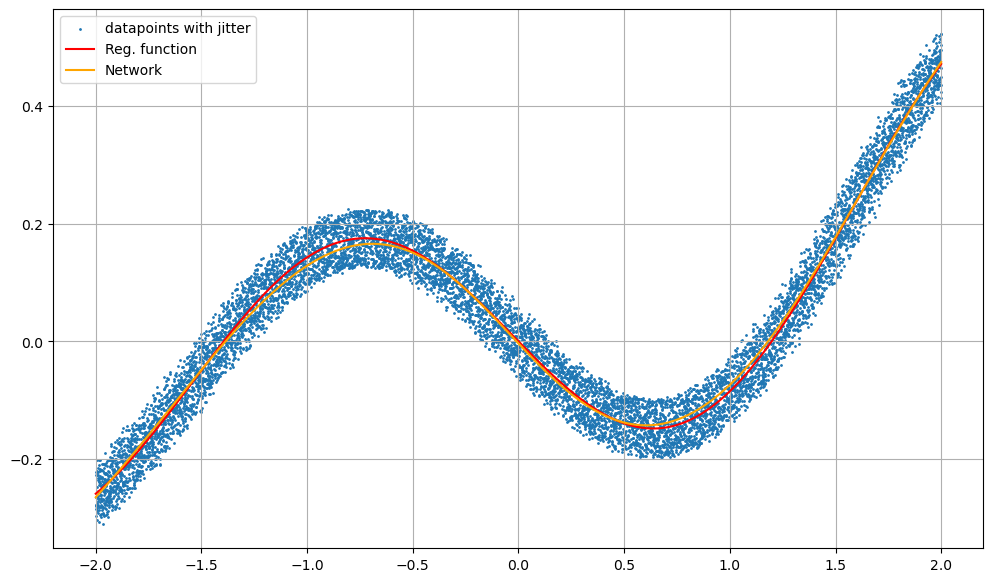

In [248]:
# Plotting the data and the function

plt.scatter(*data_reg1d, s=1, label='datapoints with jitter')
plt.plot(data_reg1d[0], test_function(data_reg1d[0]), c='r', label='Reg. function')
plt.plot(data_reg1d[0], net(torch.tensor(data_reg1d[0].reshape(-1,1)).float()).detach().numpy(), c='orange', label='Network')
plt.legend()
plt.grid()
plt.show()

***
**Exercise**

Change the some of the activation functions from ***tanh*** to ***ReLU*** (the Recitfying Linear Unit) in the network structure (see ***forward()*** function) and see how it performs! Which major difference do you observe?

Tipp: You can also execute the cell below to see the extrapolation behaviour if it is not immediately obvious to you.
***

You see, our network does its job. Let's see how it performs for extrapolation...

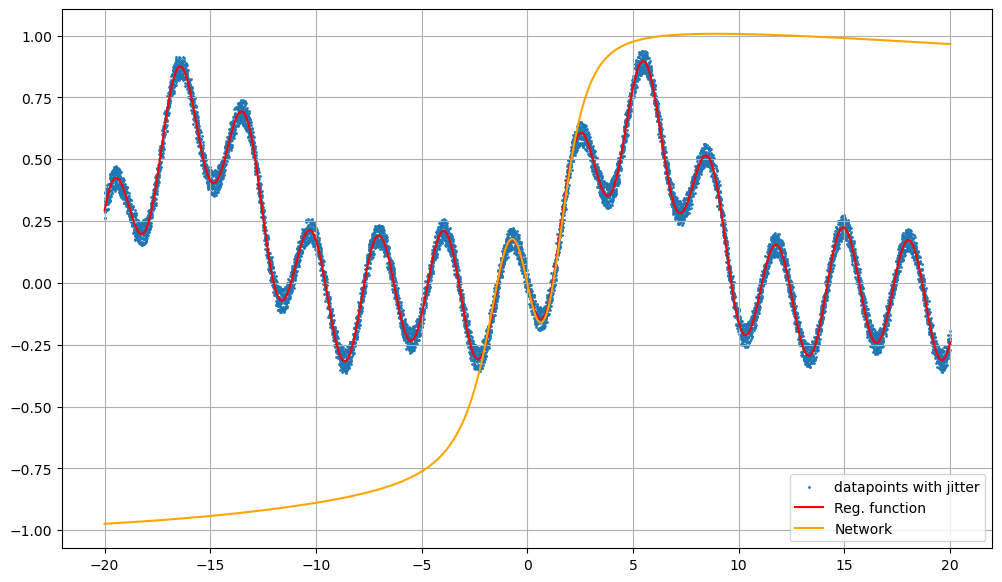

In [228]:
extrapolation = jittered_function([-20,20], 10000, 0.05)

# Plotting the data and the function

plt.scatter(*extrapolation, s=1, label='datapoints with jitter')
plt.plot(extrapolation[0], test_function(extrapolation[0]), c='r', label='Reg. function')
plt.plot(extrapolation[0], net(torch.tensor(extrapolation[0].reshape(-1,1)).float()).detach().numpy(), c='orange', label='Network')
plt.legend()
plt.grid()
plt.show()

**Important lesson learned**: Networks are really good local regressors, but should not be trusted blindly for extrapolation!<br>

With this in mind, let's export the network to a pytorch compatible format and an ONNX format for application on the grid

In [229]:
### Pytorch
torch.save(net, "./network/test_net.pt")

### ONNX
torch.onnx.export(net,                                            # model being run
                  x_train[:1],                                    # model example input (or a tuple for multiple inputs)
                  "./network/test_net.onnx",                     # where to save the model (can be a file or file-like object)
                  export_params=True,                             # store the trained parameter weights inside the model file
                  opset_version=14,                               # the ONNX version to export the model to: https://onnxruntime.ai/docs/reference/compatibility.html
                  do_constant_folding=True,                       # whether to execute constant folding for optimization
                  input_names=['input'],                          # the model's input names
                  output_names=['output'],                        # the model's output names
                  dynamic_axes={'input': {0: 'batch_size'},       # variable length axes
                                'output': {0: 'batch_size'}})

========== Diagnostic Run torch.onnx.export version 2.1.0.dev20230331 ==========
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX provides very nice functionalities, such as a checker to see whether your model has been exported correctly

In [230]:
### Define a simple function to check the ONNX model
def check_onnx(path="./network/test_net.onnx"):
    try:
        onnx_model = onnx.load(path)
        onnx.checker.check_model(onnx_model)
        print("ONNX checker: Success!")
    except:
        print("Failure in ONNX checker!")

### ONNX checker
check_onnx(path="./network/test_net.onnx")

ONNX checker: Success!


So far we have: Trained a neural network, plotted it against data and seen how to interface with the ONNX framework. It's time to apply your network now in O2Physics to see that it produces the same results as here (and how to actually apply it!). For this we will use the task **O2Physics/Tutorials/ML/applyOnnxModel.cxx**.<br>
Currently the task is hardcoded. It only operates on predefined data, however it is of course possible to apply the ONNX model on any other data that is compatible with the trained network. This could be for example track properties like <font color="LightBlue">track.tpcInnerParam()</font>, <font color="LightBlue">track.P()</font> or <font color="LightBlue">track.Tgl()</font> or any other float / int / string / ... that you would like to evaluate your model with.

First we execute our model for some values here in the Jupyter Notebook

In [231]:
### Let's create some datapoints

datapoints = torch.tensor([[0.5],[np.pi],[0.],[0.001],[-3.]])

output = net(datapoints.float()).detach().numpy()

print("Input values:\n", np.round(datapoints.flatten().detach().numpy(),6))
print("\nNetwork values:\n", np.round(output.flatten(),6)) # Increase '6' in order to get higher precision

Input values:
 [ 5.000000e-01  3.141593e+00  0.000000e+00  1.000000e-03 -3.000000e+00]

Network values:
 [-0.152286  0.835293 -0.003236 -0.003633 -0.552738]


Now that we have some reference values, let's execute the O2Physics example task. For this, put your model in the directory where you have installed O2Physics (e.g. <font color='LightBlue'>[path]/O2Physics</font>, then <font color='LightBlue'>cp ./network/test_net.onnx [path]</font>). Then you can execute the O2Physics task as

<br>
<center>
<font color='LightBlue'>o2-analysistutorial-onnx-example --modelPath test_net.onnx --enableOptimizations 1</font>
</center>
<br>

Then you should see the same values being printed out as info-messages. Slight differences between the results can appear because the values are here rounded to 6 decimal places. Just increase the number in order to get fully matching results.

<br>
<center>
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉<br>


Congratulations, you have successfully trained a network in PyTorch and applied it in $\text{O}^2$!<br>


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
</center>

Fun fact: The neural network "Trainer" class was almost completely generated by OpenAI's ChatGPT. This made my life quite a bit simpler. 😉

## 4) Application on real data - TPC PID calibration

The following application was made for the TPC PID calibration in Run 3 of ALICE. It is meant to replace the spline approach which was used during Run 1 and 2. Due to its inherent capapbilities of fitting multidimensional functions, the neural network approach can learn cross-variable correlations and can optimize N$\sigma$ distribuitions multidimensionally. Since a theoretic approximation of the specific energy loss per unit distance in the TPC gas volume is known (Bethe-Bloch function using the truncated mean estimation for the dE/dx signal), a ratio to the Bethe-Bloch curve can be made. This takes out a significant amount of correlation in momentum vs. dE/dx such that the final neural network only has to correct the ratio from few percent to the permille-level. The goal was a precision of $\leq 5 {}^\text{o}\mkern-5mu/\mkern-3mu_\text{oo}$ and better than $0.1\sigma$.<br>

The following neural network was trained on the LHC22q, pass2 data.

In [232]:
sys.path.append("./classes")
from extract_from_root import *

### Self-written class in uproot3 to load simple root trees in python
cload = load_tree()

### Loading the necessary data
LABELS_X = ['fTPCInnerParam', 'fTgl', 'fSigned1Pt', 'fMass', 'fNormMultTPC', 'fNormNClustersTPC']
LABELS_Y = ['fTPCSignal', 'fInvDeDxExpTPC']

labels, data_LHC22q = cload.load(use_vars=[*LABELS_Y, *LABELS_X], path="./LHC22q/data.root")

mask_X = []
mask_y = []
for l in labels:
    mask_X.append(l in LABELS_X)
    mask_y.append(l in LABELS_Y)

X = data_LHC22q[:,mask_X]
y = (data_LHC22q[:,mask_y].T[0].flatten()*data_LHC22q[:,mask_y].T[1].flatten())

The data is loaded now. Let's see how ratio-distributions look like without secondary corrections...

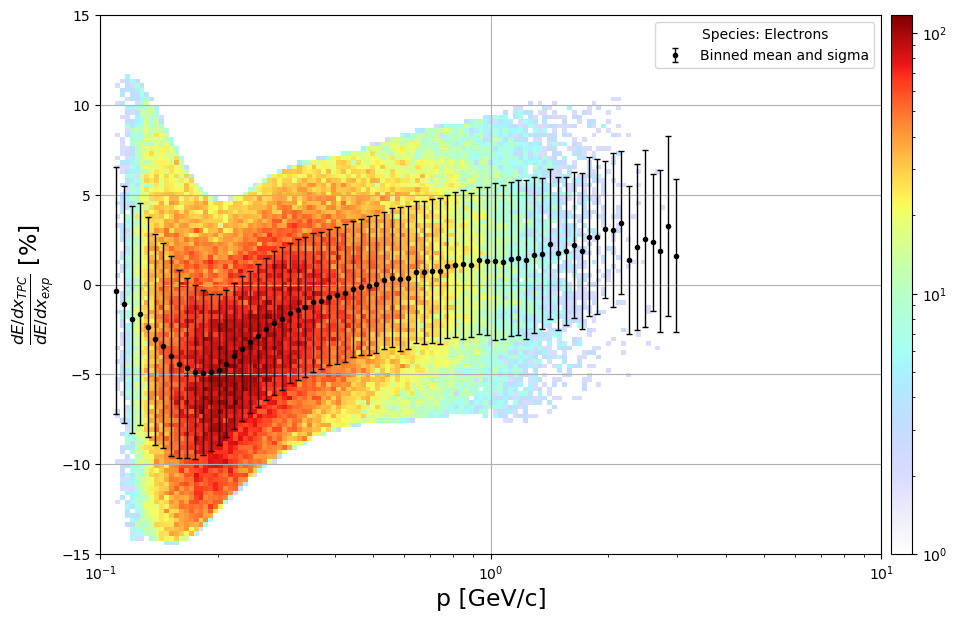

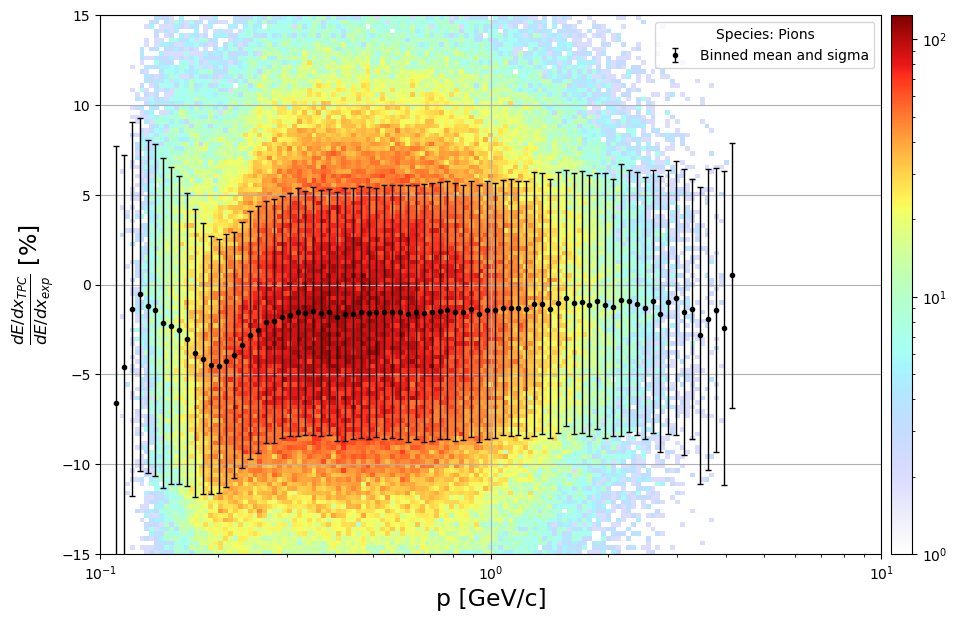

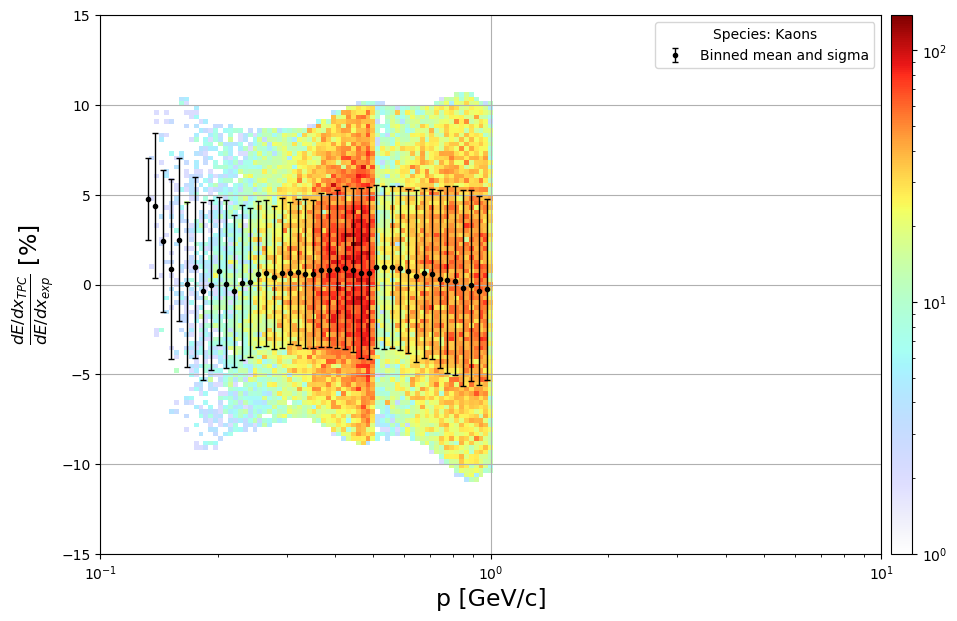

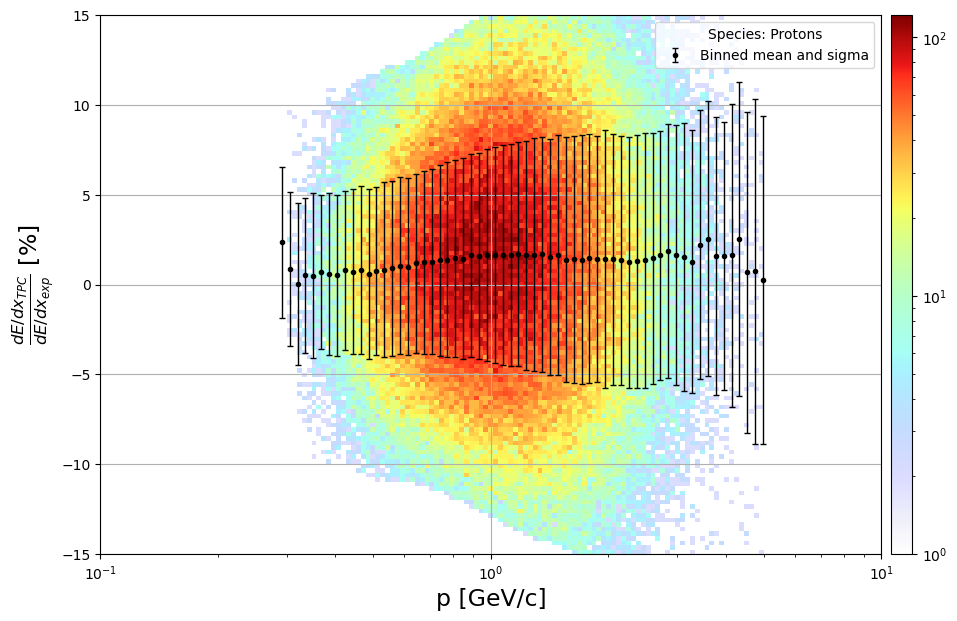

In [233]:
def plotting(x_data, y_data, mode='net'):

    ### Some prior settings
    jet_map = matplotlib.cm.jet(np.arange(matplotlib.cm.jet.N))
    jet_map[:,-1] = np.linspace(0, 1, matplotlib.cm.jet.N)
    jet_map_alpha = ListedColormap(jet_map)

    particles = ['Electrons', 'Pions', 'Kaons', 'Protons']
    range_hists = [-1.,1.]

    ### Plotting the data in histograms
    x_space = np.logspace(range_hists[0], range_hists[1], 20*8)
    if mode=='ratio':
        y_space = np.linspace(-15., 15., 20*6)
        description = r'$\frac{dE/dx_{TPC}}{dE/dx_{exp}}$ [%]'
    elif mode=='net':
        y_space = np.linspace(-3., 3., 20*6)
        description = r'$\frac{dE/dx_{TPC} - (dE/dx_{exp} \cdot net)}{(dE/dx_{exp} \cdot net)}$ [σ]'
    
    plt.hist2d(x_data, y_data, bins=(x_space, y_space), range=[[-1.,1.],[-10.,10.]], cmap=jet_map_alpha, norm=colors.LogNorm())
    plt.colorbar(pad=0.01, aspect=25)
    
    # mean values for assigned species
    bins_sig_mean = 100

    binned_mean = sc.stats.binned_statistic(np.log10(x_data), y_data, statistic='mean', bins=bins_sig_mean,range=range_hists)
    binned_sigma = sc.stats.binned_statistic(np.log10(x_data), y_data, statistic='std', bins=bins_sig_mean,range=range_hists)
    
    plt.errorbar(10**np.linspace(range_hists[0],range_hists[1], bins_sig_mean), binned_mean[0], yerr=binned_sigma[0],
                fmt='.', capsize=2., c='black', ls='none', elinewidth=1., label="Binned mean and sigma")
            

    plt.xlabel(r'p [GeV/c]', fontsize=17)
    plt.ylabel(description, fontsize=17)
    plt.xscale('log')
    plt.grid()
    plt.legend(title="Species: " + particles[i])
    plt.show()

for i, mass in enumerate(np.sort(np.unique(data_LHC22q[:,labels=='fMass'].flatten()))):

    mask_pred = data_LHC22q[:,labels=='fMass'].flatten() == mass
    y = ((data_LHC22q[:,labels=='fTPCSignal'].flatten()*data_LHC22q[:,labels=='fInvDeDxExpTPC'].flatten())[mask_pred]-1.)*100

    plotting(data_LHC22q[:,labels=='fTPCInnerParam'].flatten()[mask_pred], y, mode='ratio')

In [234]:
### Loading the neural network trained on LHC22f data
ort_session = ort.InferenceSession("./LHC22q/net.onnx")

def network(data, ort_session=ort_session):
    return np.array(ort_session.run(None, {'input': (torch.tensor(data).float()).numpy()}))

Now the network and the data is loaded. Let's see whether the network has learned well...<br>

The network was trained to learn the predictions for the mean correction factor and a sigma estimation of the $\text{N}\sigma$ distributions. All of this with a rather small network (3 hidden layers, 8 neurons per layer), that learns a 6D underlying parameter space.

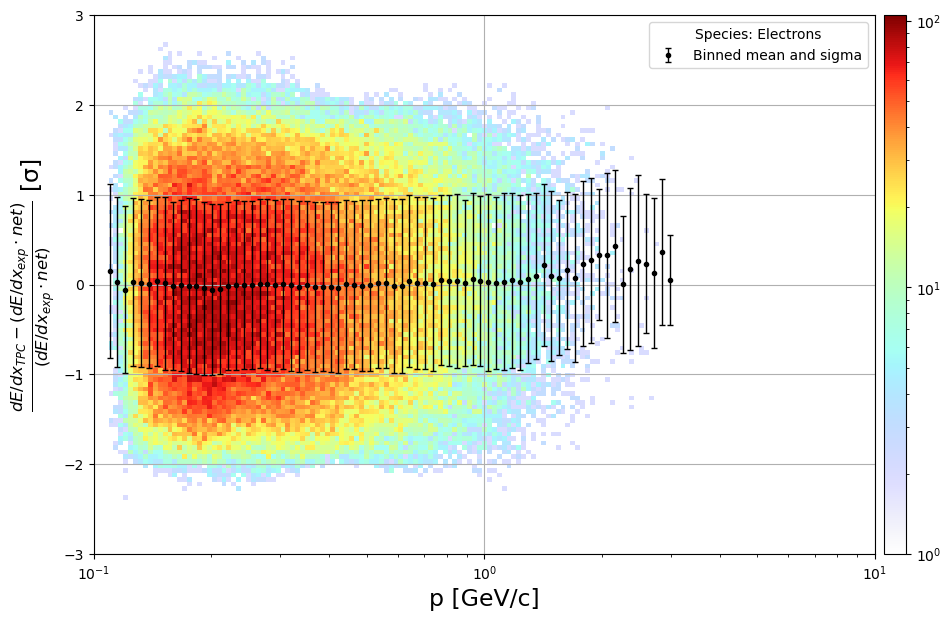

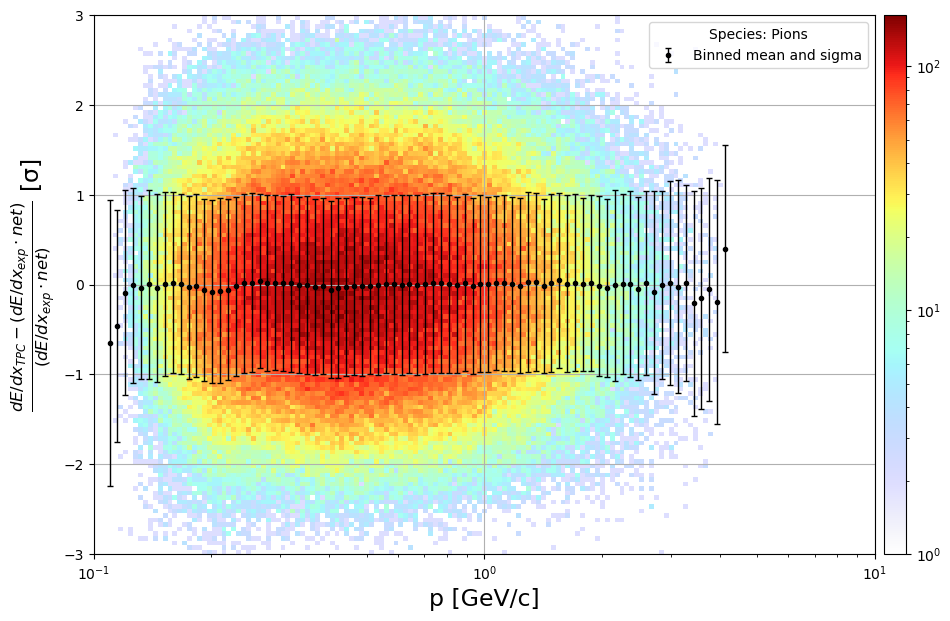

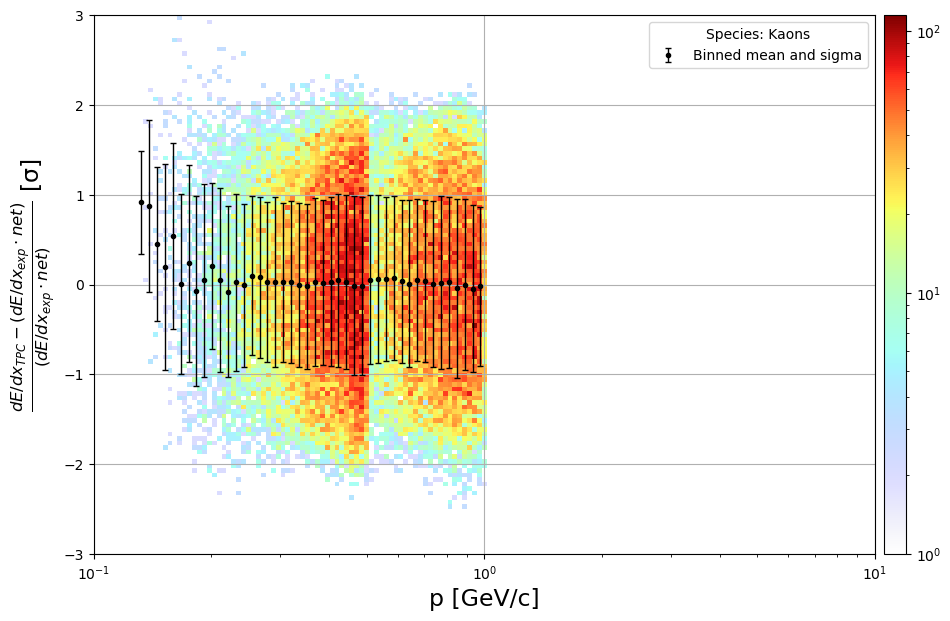

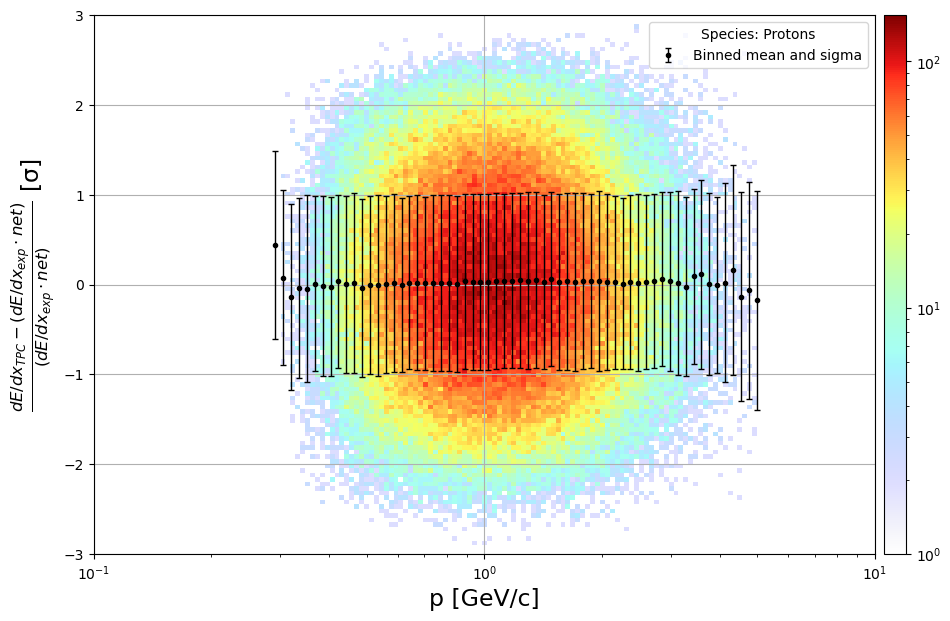

In [235]:
for i, mass in enumerate(np.sort(np.unique(data_LHC22q[:,labels=='fMass'].flatten()))):

    mask_pred = data_LHC22q[:,labels=='fMass'].flatten() == mass
    net_x = X[mask_pred]
    net_out = network(net_x,ort_session=ort_session)
    net_y = (((data_LHC22q[:,labels=='fTPCSignal'].flatten()*data_LHC22q[:,labels=='fInvDeDxExpTPC'].flatten())[mask_pred] - net_out.T[0].flatten()))/(net_out.T[1].flatten()-net_out.T[0].flatten())

    plotting(data_LHC22q[:,labels=='fTPCInnerParam'].flatten()[mask_pred], net_y, mode='net')

# Miscellaneous

/var/folders/12/0hh3vwh15c98tyd4w4bw6dt80000gn/T/ipykernel_83363/679202579.py:36: UserWarning: Matplotlib is currently using module://ipympl.backend_nbagg, which is a non-GUI backend, so cannot show the figure.
  fig.show()


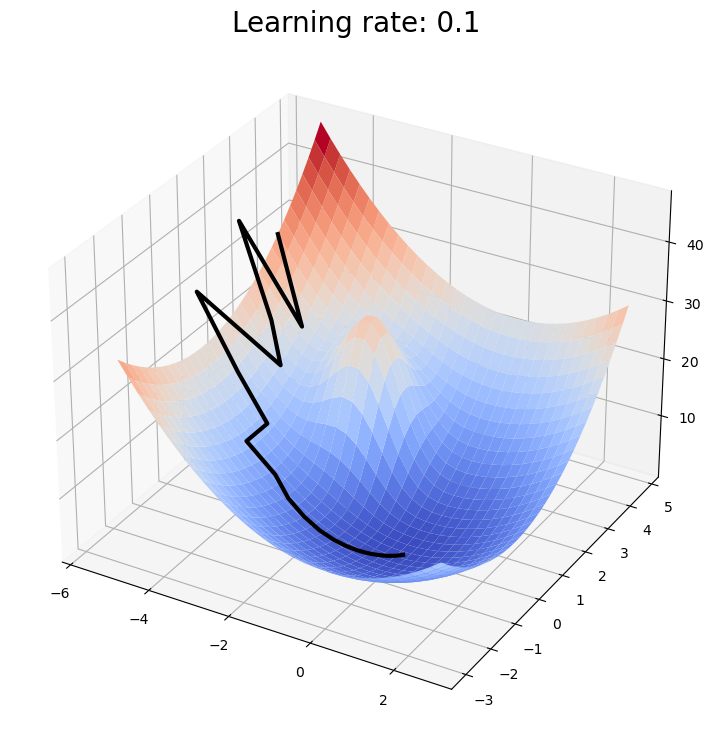

In [162]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import torch

fig, ax = plt.subplots(figsize=(16,9),subplot_kw={"projection": "3d"})

# Make data.
def function(x, y):
    return x**2 + y**2

def bump(X, Y, a=1):
    return a*np.exp(-((X)**2 + (Y)**2))

X = np.arange(-5,3,0.25)
Y = np.arange(-3,5,0.25)

X, Y = np.meshgrid(X, Y)
Z = function(X,Y) + bump(X+2,Y-2,20)

learning_rate = 0.1
values = np.array([[-5,3]])
for i in range(100):
    values = np.vstack((values, np.array([values[-1] - learning_rate*(2*values[-1] - 40*bump(values[-1,0]+2, values[-1,1]-2, 20)*(values[-1]+np.array([2,-2])))]) ))

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       rstride=1, cstride=1, shade=False)
plt.plot(*values.T, function(values.T[0], values.T[1]), linewidth=3, c="black", zorder=3)

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title("Learning rate: " + str(learning_rate), {'fontsize': 20})

fig.show()
# fig.savefig("GradientDescent.png", transparent=True)